In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas_ta as ta
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from fredapi import Fred
# %matplotlib inline

2025-07-30 09:58:13.218348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 09:58:13.219117: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 09:58:13.223781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-30 09:58:13.235924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753862293.255903  747927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753862293.26

In [2]:
#Run to get interactive plots
%matplotlib notebook

In [2]:
#Setup my Fred API
fred = Fred(api_key="15a7c21c16a08c2328d8afe299313b9d")

In [17]:
#Data preprocessing and feature building
#Along with the daily returns and volume, the technical indicators have also been used
#Moreover, macro indicators may carry information about the market behaviour from national and global level economical events

# Download stock data
df = yf.download("MSFT", start="2015-01-01", end="2025-01-01", auto_adjust=False)
sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-01-01', auto_adjust=False)

df['Return'] = df['Close'].pct_change()
# df['Log_Return'] = np.log1p(df['Close'].pct_change())
df['Lag1'] = df['Return'].shift(1)
df['Lag2'] = df['Return'].shift(2)
df['Lag3'] = df['Return'].shift(3)

# Moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['Momentum'] = df['MA_5'] - df['MA_10']

#volatility
df['Volatility'] = df['Return'].rolling(window=10).std()

# Add S&P 500 features
df['SP500_Close'] = sp500['Close']
df['SP500_Return_lag1'] = sp500['Close'].pct_change().shift(1)



# Fix potential MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#Add all the nice indicators to the df
df.ta.rsi(length=14, append=True)
df.ta.macd(append=True)
df.ta.bbands(length=20, std=2, append=True)
df.ta.atr(length=14, append=True)
df.ta.obv(append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=50, append=True)

#Add macro features from Fred api such as inflation, interest rates and GDP
macros = pd.DataFrame({
         'CPI_Inflation': fred.get_series("CPIAUCSL"),
         'Interest_Rate': fred.get_series("FEDFUNDS"),
         'GDP': fred.get_series('GDP')}).resample('B').ffill()

# Combine the macro features to the primary features
# df = df.merge(macros, left_index=True, right_index=True)

# Add target variable: next-day MSFT price
# df['Target'] = df['Close'].shift(-1)
#Log target
# df['Target'] = np.log(df['Close'] / df['Close'].shift(1))
df['Target'] = np.log(df["Return"] + 1)
#remove nan values
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
########USE Feature importance + PCA to remove less important features, use correlation matrix too

###Also use k fold CV to improve against overfitting

x = df[["SP500_Return_lag1", "SP500_Close", "Volatility", "MA_5", "MA_10", "RSI_14", "MACD_12_26_9", "OBV", "Volume"]]
y = df['Target']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# ---------------------- GP Regression ----------------------
# Define kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e1))
# kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel()
# Fit GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(x_train_scaled, y_train)

/home/devanshu/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5, normalize_y=True)

In [19]:

# Use the gp on the test dataset to make predictions
y_pred_test, y_std_test = gp.predict(x_test_scaled, return_std=True)
#y_pred_train, y_std_train = gp.predict(x_train_scaled, return_std=True)
residuals = y_test.values - y_pred_test

In [20]:
#Check accuracy of the results
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:", root_mean_squared_error(y_test, y_pred_test))
print("R-squared score", r2_score(y_test,y_pred_test))
print("MAE", mean_absolute_error(y_test,y_pred_test))

#In case of overfitting, test the accuracy of the model on the training data
# print("MSE Train:", mean_squared_error(y_pred_train, y_train))

MSE: 0.00033772202622807396
RMSE: 0.018377214865916813
R-squared score -0.1274245320951235
MAE 0.014405948091912875


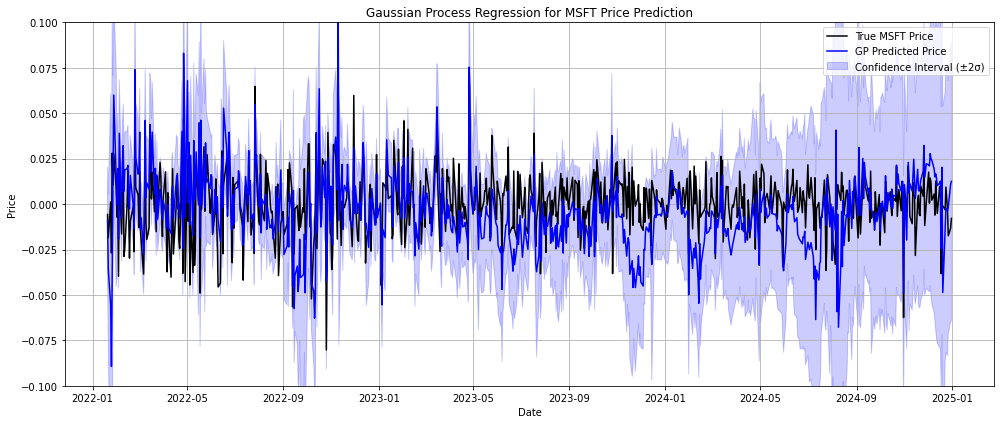

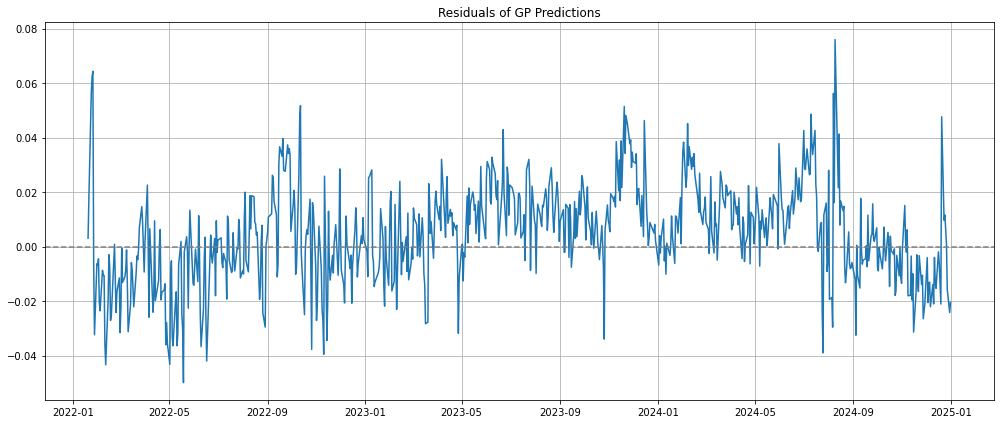

In [21]:
# ---------------------- Visualization ----------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), y_test.values, label="True MSFT Price", color='black')
plt.plot(y_test.index.to_numpy(), y_pred_test, label="GP Predicted Price", color='blue')
plt.fill_between(y_test.index.to_numpy(), y_pred_test - 2*y_std_test, y_pred_test + 2*y_std_test,
                 color='blue', alpha=0.2, label='Confidence Interval (±2σ)')
plt.title("Gaussian Process Regression for MSFT Price Prediction")
plt.ylim(-0.1,0.1)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), residuals, label="Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals of GP Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()


Explained variance ratio: [0.47148983 0.23043494 0.11118902 0.10214729]


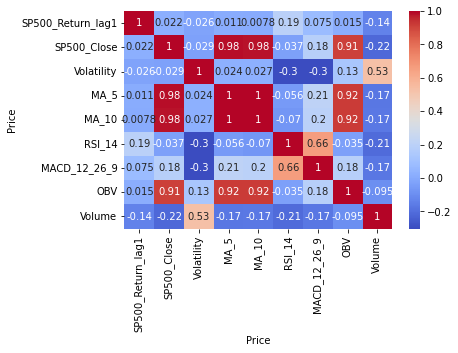

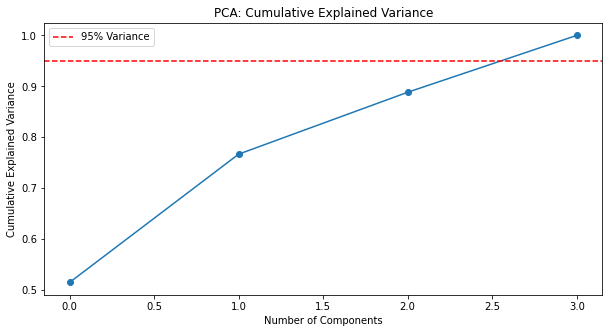

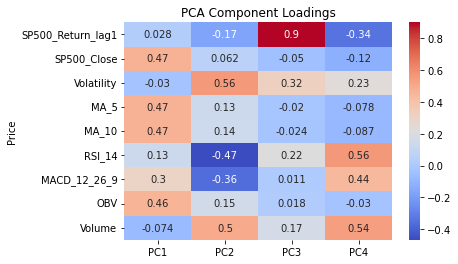

In [22]:
#Check the correlation among the features
sns.heatmap(x.corr(), annot=True, cmap="coolwarm")

#Apply PCA
pca = PCA(n_components=4)  
x_pca_train_scaled = pca.fit_transform(x_train_scaled)
x_pca_test_scaled = pca.transform(x_test_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

#Visualize the usefulness of PCA
pca_full = PCA().fit(x_pca_train_scaled)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.legend()
plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=x.columns
)
sns.heatmap(loadings, annot=True, cmap="coolwarm")
plt.title("PCA Component Loadings")
plt.show()



In [23]:
# Use the PCs to train the GP

gp.fit(x_pca_train_scaled, y_train)


# Predict
y_pca_pred_test, y_pca_std_test = gp.predict(x_pca_test_scaled, return_std=True)
y_pca_pred_train, y_pca_std_train = gp.predict(x_pca_train_scaled, return_std=True)

residuals_pca = y_test.values - y_pca_pred_test

In [24]:
#Check accuracy of the results
print("MSE:", mean_squared_error(y_test, y_pca_pred_test))
print("RMSE:", root_mean_squared_error(y_test, y_pca_pred_test))
print("R-squared score", r2_score(y_test,y_pca_pred_test))
print("MAE", mean_absolute_error(y_test,y_pca_pred_test))
# print("MSE Train:", mean_squared_error(y_pca_pred_train, y_train))

MSE: 0.00043130060722090926
RMSE: 0.020767778100242433
R-squared score -0.43981987411147094
MAE 0.015711792699044335


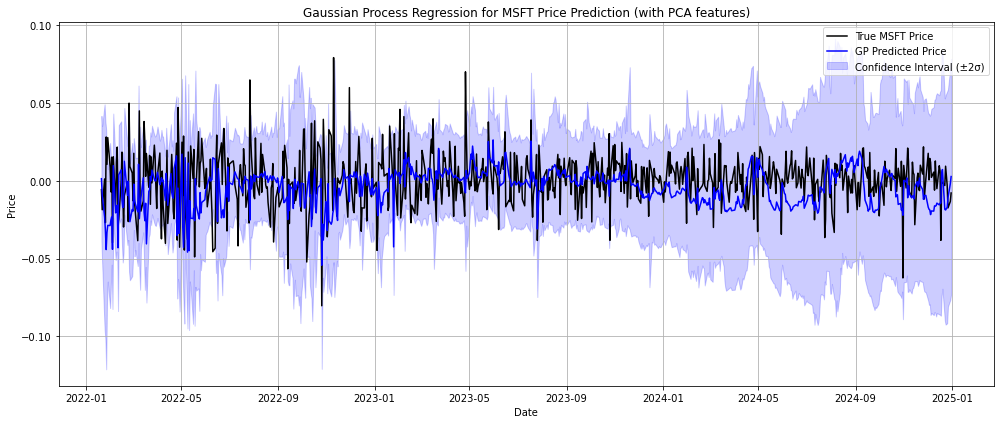

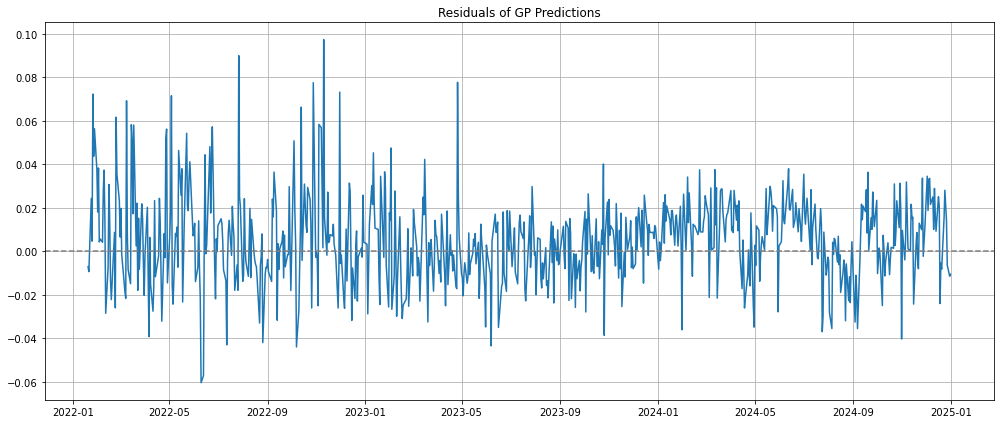

In [25]:
# ---------------------- Visualization ----------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), y_test.values, label="True MSFT Price", color='black')
plt.plot(y_test.index.to_numpy(), y_pca_pred_test, label="GP Predicted Price", color='blue')
plt.fill_between(y_test.index.to_numpy(), y_pca_pred_test - 2*y_pca_std_test, y_pca_pred_test + 2*y_pca_std_test,
                 color='blue', alpha=0.2, label='Confidence Interval (±2σ)')
plt.title("Gaussian Process Regression for MSFT Price Prediction (with PCA features)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), residuals_pca, label="Residuals (with PCA features)")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals of GP Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()


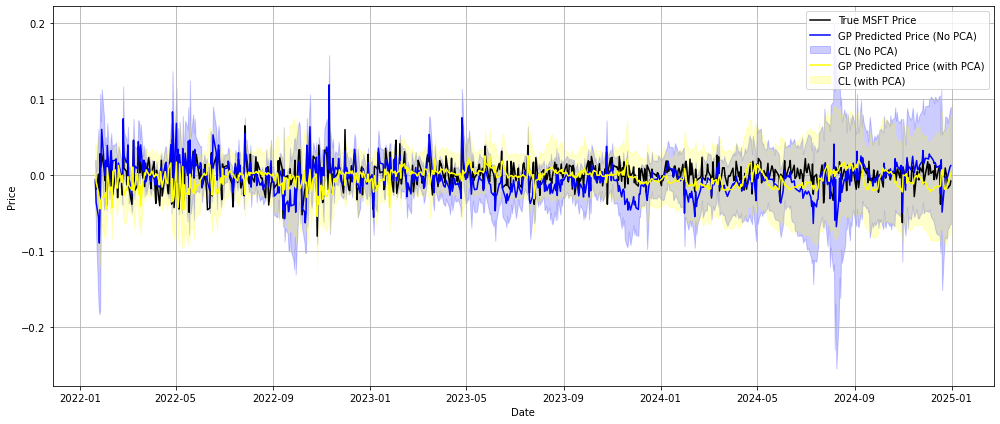

In [26]:
#Compare the gp's with and without PCA 

#first plot the true dataset
plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), y_test.values, label="True MSFT Price", color='black')

#Then plot the gp predictions without PCA along with the confidence intervals
plt.plot(y_test.index.to_numpy(), y_pred_test, label="GP Predicted Price (No PCA)", color='blue')
plt.fill_between(y_test.index.to_numpy(), y_pred_test - 2*y_std_test, y_pred_test + 2*y_std_test,
                 color='blue', alpha=0.2, label='CL (No PCA)')

#Next plot the gp predictions and confidence intervals with the principal components
plt.plot(y_test.index.to_numpy(), y_pca_pred_test, label="GP Predicted Price (with PCA)", color='yellow')
plt.fill_between(y_test.index.to_numpy(), y_pca_pred_test - 2*y_pca_std_test, y_pca_pred_test + 2*y_pca_std_test,
                 color='yellow', alpha=0.2, label='CL (with PCA)')

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

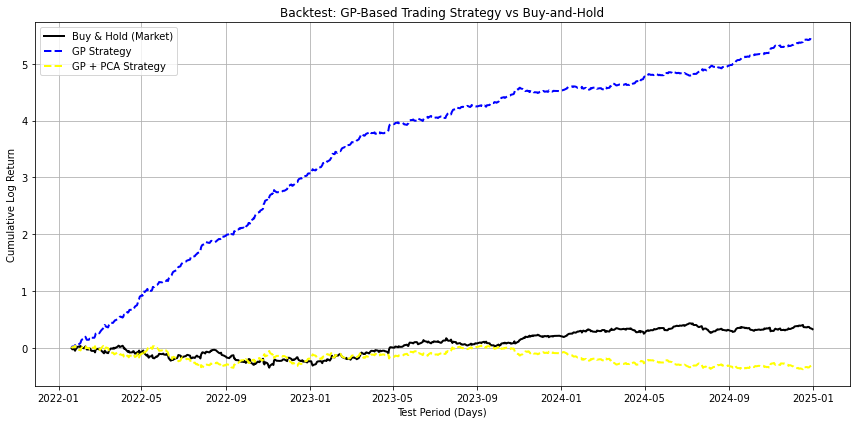

In [47]:
positions = np.where(y_pred_test > 0, 1, -1)  #if positive then +1 else -1
positions_pca = np.where(y_pca_pred_test > 0, 1, -1)  #Same for the gp + PCA model
strategy_return = positions * y_test    #multiply the positions with the actual returns
strategy_return_pca = positions_pca * y_test #Same for the gp + PCA model
 
strategy_cumulative = np.cumsum(strategy_return)  #cumulative return using the GP model
strategy_cumulative_pca = np.cumsum(strategy_return_pca) #Same for the gp + PCA model
market_cumulative = np.cumsum(y_test) #cumulative returns of the market


#visualize the strategy
plt.figure(figsize=(12, 6))
plt.plot(market_cumulative, label='Buy & Hold (Market)', color='black', linewidth=2)
plt.plot(strategy_cumulative, label='GP Strategy', color='blue', linestyle='--', linewidth=2)
plt.plot(strategy_cumulative_pca, label='GP + PCA Strategy', color='yellow', linestyle='--', linewidth=2)
plt.title("Backtest: GP-Based Trading Strategy vs Buy-and-Hold")
plt.xlabel("Test Period (Days)")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()